# Computing CrowdTruth metrics for SUMO ticket annotations

This notebook computes CrowdTruth metrics for our SUMO ticket annotations. 

It is based on `Free Input Task - Person Annotation in Video.ipynb` from the CrowdTruth repo. 
<br><br><br>
**Input**: Ticket annotation JSON containing only annotated tickets

**Output**: CrowdTruth quality metrics for workers (taggers), tickets, and tags
<br><br><br>
Make sure you install from `requirements.txt` before running this notebook

`pip install -r requirements.txt`

In [1]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from autocorrect import spell

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wfenton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/wfenton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/wfenton/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/wfenton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Preprocessing

Take a JSON file containing annotated tickets, convert it to a CSV so that we can import it using pandas

In [2]:
from pathlib import Path

# this adds the CANOSP root to the path, so we can import from there
import sys
sys.path.append('../')

from json_to_crowdtruth_csv import ticket_to_csv

# root of the repository
canosp_root_path = Path("./..")

# tickets.csv is the 200MB ticket JSON from Google Drive
input_json_path = canosp_root_path / "data/tickets.json"
output_csv_path = canosp_root_path / "data/crowdtruth_tickets.csv"

ticket_to_csv(input_json_path, output_csv_path)

Taggers: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Finished writing annotations to ../data/crowdtruth_tickets.csv
319303 tickets (0 duplicates)
1645 annotations (0 duplicates)


Load the CSV into a pandas dataframe and display the format

In [3]:
import pandas as pd

input_data = pd.read_csv(output_csv_path)
input_data.head()

,_unit_id,_created_at,_id,_started_at,_worker_id,keywords
0,1271065,1/1/2020 00:02:00,0,1/1/2020 00:00:00,5,"[""windows-8.1"",""firefox"",""thunderbird"",""""]"
1,1271065,1/1/2020 00:02:00,1,1/1/2020 00:00:00,6,"[""browser"",""thunderbird"",""firefox"",""defaults"",..."
2,1271066,1/1/2020 00:02:00,2,1/1/2020 00:00:00,5,"[""mac-os-10.6.8"",""firefox"",""ui""]"
3,1271066,1/1/2020 00:02:00,3,1/1/2020 00:00:00,6,"[""customize"",""search"",""replace"",""mac"",""osx"",""""]"
4,1271071,1/1/2020 00:02:00,4,1/1/2020 00:00:00,5,"[""non-english"",""ruassian""]"


CrowdTruth config

In [4]:
class CanospConfig(DefaultConfig):
    inputColumns = []
    outputColumns = ["keywords"]
    customPlatformColumns = []
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = []
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
            # remove square brackets from annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[]','no tags'))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(']',''))
            # remove the quotes around the annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('"',''))

        return judgments


Load the data

In [5]:
data, config = crowdtruth.load(
    file = str(output_csv_path),
    config = CanospConfig()
)

data['judgments'].head()

,output.keywords,output.keywords.count,output.keywords.unique,unit,worker,started,submitted,duration,job
judgment,,,,,,,,,
0,"{'windows-8.1': 1, 'firefox': 1, 'thunderbird'...",4,4,1271065,5,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth_tickets
1,"{'browser': 1, 'thunderbird': 1, 'firefox': 1,...",7,7,1271065,6,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth_tickets
2,"{'mac-os-10.6.8': 1, 'firefox': 1, 'ui': 1}",3,3,1271066,5,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth_tickets
3,"{'customize': 1, 'search': 1, 'replace': 1, 'm...",6,6,1271066,6,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth_tickets
4,"{'non-english': 1, 'ruassian': 1}",2,2,1271071,5,2020-01-01,2020-01-01 00:02:00,120,../data/crowdtruth_tickets


## Compute CrowdTruth metrics

In [6]:
results = crowdtruth.run(data, config)

results.keys()

dict_keys(['jobs', 'units', 'workers', 'judgments', 'annotations'])

In [7]:
taggers = {
    0 : "SUMO",
    1 : "Martin",
    2 : "Yuan",
    3 : "Will",
    4 : "Ana",
    5 : "Michael",
    6 : "Eve",
    7 : "Brady",
    8 : "Joni",
    9 : "Roland"
}

# Results

## Ticket and Tag Quality

### Tag quality scores

**worker**: tagger ID

**unit**: number of tickets annotated by the tagger

**uqs**: unit quality score (0-1) - expresses the overall worker agreement over one ticket

In [8]:
unit_results = results["units"]

unit_results["name"] = unit_results["worker"].map(taggers)

unit_results.rename(columns={'output.keywords': 'tags', 'unit_annotation_score': 'tag_quality'}, inplace=True)

unit_results[["worker", "name", "uqs", "tags", "tag_quality"]].sort_values("uqs", ascending=False)

,worker,name,uqs,tags,tag_quality
unit,,,,,
1271137,2,Yuan,0.816497,"{'firefox': 2, 'password': 2, 'sync': 2, '': 2...","{'firefox': 1.0, 'password': 1.0, 'sync': 1.0,..."
1274645,3,Will,0.790780,"{'off-topic': 3, 'email': 1}","{'off-topic': 1.0, 'email': 0.3586575724474523}"
1271065,2,Yuan,0.566947,"{'windows-8.1': 1, 'firefox': 2, 'thunderbird'...","{'windows-8.1': 0.5688587461654714, 'firefox':..."
1276809,2,Yuan,0.566947,"{'upload': 2, 'quit': 2, 'warning': 2, 'add-fe...","{'upload': 1.0, 'quit': 1.0, 'warning': 1.0, '..."
1276638,3,Will,0.562752,"{'proxy': 3, 'credentials': 1, 'authentication...","{'proxy': 1.0, 'credentials': 0.14449457318775..."
...,...,...,...,...,...
1274635,3,Will,0.000000,"{'information-question': 1, 'support-forum': 1...","{'information-question': 0.4251665465019833, '..."
1274637,3,Will,0.000000,"{'extension': 1, 'desktop': 1, '71': 1, 'user-...","{'extension': 0.4251665465019833, 'desktop': 0..."
1271127,2,Yuan,0.000000,"{'firefox': 1, 'firefox-70': 1, 'extension': 1...","{'firefox': 0.5688587461654714, 'firefox-70': ..."


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# set plot size
plt.rcParams['figure.figsize'] = [8, 5]

Text(0, 0.5, 'Count')

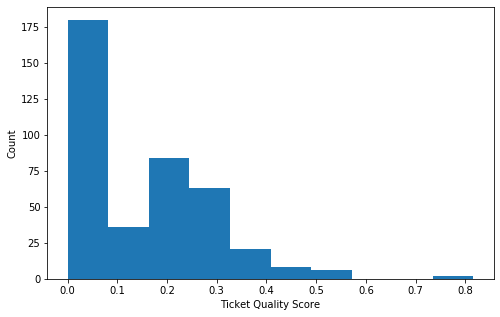

In [10]:
plt.hist(unit_results["uqs"])
plt.xlabel("Ticket Quality Score")
plt.ylabel("Count")

## Tagger Quality

### Tagger quality scores

**worker**: tagger ID

**unit**: number of tickets annotated by the tagger

**wqs**: worker quality score (0-1) - measures the overall agreement of one tagger with the other taggers. function of `wwa` and `wsa`

**wwa**: worker-worker agreement (0-1) - measures the average pairwise agreement between a tagger and all other taggers, indicating how close a tagger performs compared to taggers solving the same task

**wsa**: worker-sentence agreement (0-1) - the agreement of a tagger with all the taggers that annotated the same ticket

In [11]:
worker_results = results["workers"]
worker_results["name"] = worker_results.index.to_series().map(taggers)

# average number of unique tags per annotation, per worker
num_tags_results = results["judgments"][["worker", "output.keywords.unique"]]
average_num_tags = num_tags_results.groupby(['worker'], as_index=True).mean()

worker_results = worker_results.join(average_num_tags)

worker_results.rename(columns={'output.keywords.unique': 'average_unique_tags', 'unit': 'tickets'}, inplace=True)

# wqs sorted by wqs, descending order 
worker_results.sort_values("wqs", ascending=False)[["name", "tickets", "average_unique_tags", "wqs", "wwa", "wsa"]]

,name,tickets,average_unique_tags,wqs,wwa,wsa
worker,,,,,,
2,Yuan,175,2.405714,0.118299,0.281037,0.420936
5,Michael,178,2.303371,0.086002,0.231091,0.372155
4,Ana,149,2.120805,0.083483,0.218677,0.381762
3,Will,194,4.515464,0.083128,0.231736,0.358719
7,Brady,195,3.605128,0.072326,0.214188,0.337673
9,Roland,151,3.311258,0.070423,0.203296,0.346408
6,Eve,254,7.007874,0.065181,0.205910,0.316551
8,Joni,151,3.695364,0.042447,0.151629,0.279938
1,Martin,160,4.962500,0.026256,0.110737,0.237103


Histogram of tagger quality scores

Text(0, 0.5, 'Count')

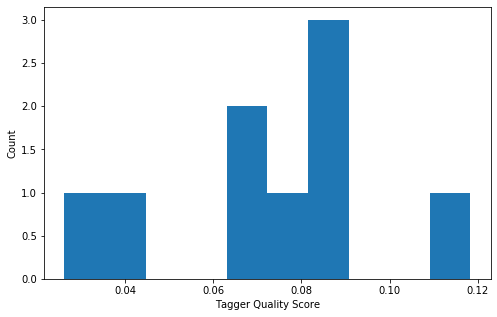

In [12]:
plt.hist(worker_results["wqs"])
plt.xlabel("Tagger Quality Score")
plt.ylabel("Count")

Plot tagger quality metrics based on number of tags per ticket

With such a low sample size I don't know how much this actually tells us, but it's kinda interesting

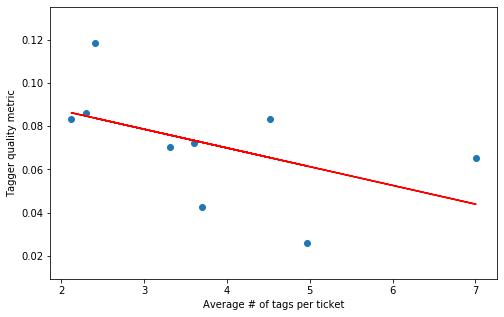

In [13]:
import numpy as np

x = worker_results["average_unique_tags"]
y = worker_results["wqs"]

plt.scatter(x, y)
plt.xlabel("Average # of tags per ticket")
plt.ylabel("Tagger quality metric")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r")